# AI4EO - Feature enhancement for land management

## Get started with the challenge

This notebook will get you started with downloading, exploring and analysing the input and output data of the challenge.

The aim of this challenge is to create AI systems that can exploit the temporal information of Sentinel-2 images into an enhanced spatial resolution. 

Your task will be to estimate a _cultivated land_ map at **2.5m** spatial resolution given as input a _Sentinel-2 time-series_ at **10m** spatial resolution, therefore resulting in a `4x` spatial resolution improvement. 

This notebook showcases how to download and process the data using [eo-learn](https://eo-learn.readthedocs.io/en/latest/index.html), a Python library specifically designed to deal with Earth Observation data. The data will be stored into `EOPatches` as `numpy` arrays and `geopandas` dataframes to facilitate processing operations. However, you can use any other Python tool of preference to process the provided data.

The notebook also showcases how to generate a valid submission file.

As per challenge rules, the following applies:
 * no data source other than the ones provided can be used to produce your outputs;
 * pre-trained models are not allowed.

**NOTE**: Code for the winning solutions will be executed to reproduce your winning submission and reviewed to ensure rules have been followed. Failure to reproduce the submission will result in its disqualification. Make sure therefore to set your random seeds and initialisations where needed.

The content of the notebook is as follows:

0. [Requirements](#requirements)

1. [Data overview](#data-overview)

   1.1. [Area of Interest](#aoi)

   1.2. [Sentinel-2 time-series](#sentinel-2)
     
   1.3. [Reference polygons](#reference)
   
   1.4. [Train data download](#train-data)
   
   1.5. [Test data download](#test-data)
   
   1.6. [Files check](#files-check)
    
2. [Validation metric](#validation-metric)
    
3. [Data processing](#data-processing)

4. [Submission example](#submission-example)

   4.1 [Prepare a submission](#prepare-a-submission)

In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Built-in modules
import os
import json
import datetime as dt
from typing import Tuple, List

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask
from eolearn.geometry import VectorToRaster

# Visualisation utilities from utils.py
from utils import get_extent, md5_encode_files

## 0. Requirements  <a name="requirements"></a>

In order to download the training data through the provided APIs you would need to set-up an account for Sentinel Hub and GeoDB. Check the following options.

#### If you are using the Euro Data Cube (EDC) resources

The accounts have been already created and configured for you, and what you need is only to retrieve the SentinelHub credentials from your dashboard and paste them below (from your EDC dashboard click on **EDC Sentinel Hub** in the _My API service subscriptions_, then click on **SHOW** credential in _API Access_ section).  

The GeoDB account is already set-up and you don't need to retrieve the credentials.

Alternatively to the dashboard, you can retrieve all credentials from the `.env` file in your home directory.

#### If you are using your own resources

You need the following accounts:

 * [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/), to download the Sentinel-2 time-series. What you need is to [create a free account](http://www.sentinel-hub.com/create_account), register an OAuth client from [your dashboard](https://apps.sentinel-hub.com/dashboard/#/account/settings) by clicking on the `Create a new OAuth client` button, set the `Client grant type` to `Client Credentials` and save the `secret` value. Paste below the `client_id` and `secret_client_id` and you are ready to go;
 * [GeoDB](https://eurodatacube.com/marketplace/services/edc_geodb), to download polygons defining the AOI and the reference land cover polygons. [Create a trial account](https://eurodatacube.com/register), and retrieve the `client_id` and `client_secret` tokens from your dashboard. 
 
#### If you cannot use the APIs

Check the challenge description for alternative options to retrieve the training data as a single compressed file. Beware that the resulting dataset is approximately 11GB. 

In [ ]:
sh_config = SHConfig()

sh_config.sh_client_id = '<your Sentinel Hub OAuth client ID>'
sh_config.sh_client_secret = '<your Sentinel Hub OAuth client secret>'

In [ ]:
geodb_client_id = '<your GeoDB client ID>'
geodb_client_secret = '<your GeoDB client secret>'

# uncomment below if running from EDC
# client = GeoDBClient()

# uncomment below if running from your own resources
# client = GeoDBClient(server_url='https://xcube-geodb.brockmann-consult.de', 
#                      auth_aud='https://xcube-users.brockmann-consult.de/api/v2', 
#                      client_id=geodb_client_id, client_secret=geodb_client_secret)

client.whoami

## 1. Data Overview <a name="data-overview"></a>

This section gives an overview of all the necessary data to train your model and how to download them. 

In particular, the data sources to download are the following:

 * a list of bounding boxes defining the training area-of-interest (AOI);
 * the Sentinel-2 L2A time-series for a 6 months period starting 1st March 2019;
 * the reference polygons defining the cultivated and non-cultivated land labels. 
 
After downloading the bounding boxes defining the AOI, we will download the images and reference data for an example bounding box. After this, we will set a workflow to download all the required training data.

**NOTE**: The download parameters **CANNOT** be modified! Otherwise you will work with the wrong input data.

In [5]:
# DO NOT CHANGE THIS
GEODB_DATABASE = 'geodb_0e5d743f-2134-4561-8946-a073b039176f'

### 1.1 Area of Interest <a name="aoi"></a>

The AOI chosen for this challenge is the [Republic of Slovenia](https://en.wikipedia.org/wiki/Slovenia) and its neighbouring countries. 

The AOI is split into 125 bounding boxes across the entire area, data for 100 bounding boxes to be used for training, and 25 for testing. The following code retrieves the bounding boxes for training from the GeoDB database.

`bboxes` is a `geopandas` GeoDataFrame holding the geometry information and a unique index identifier of the bounding box, i.e. `eop_index`.

In [6]:
bboxes = client.get_collection('ai4eo_bboxes', database=GEODB_DATABASE)

**NOTE:** The bounding boxes and all data sources used are in the UTM zone 33N, i.e. `epsg:32633`.

In [7]:
bboxes.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Plot bounding boxes

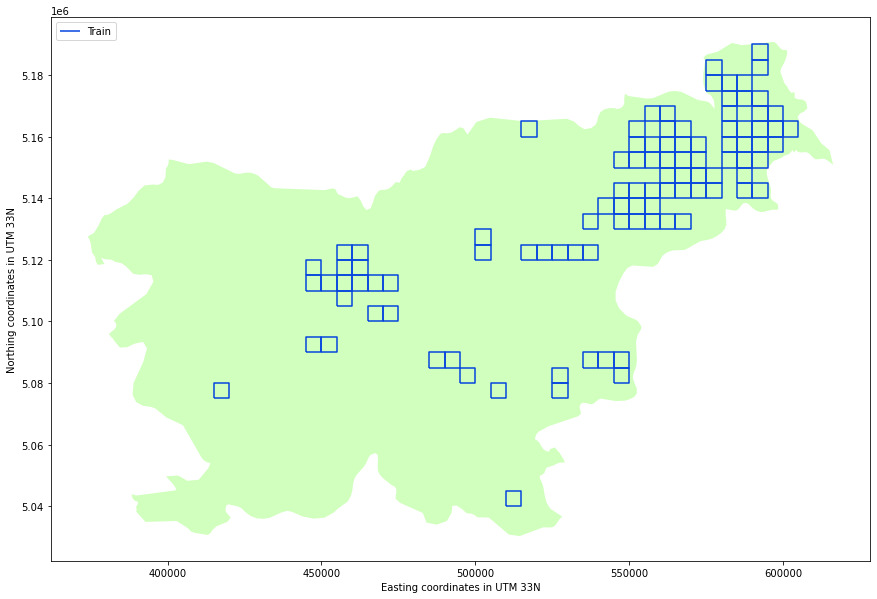

In [8]:
country = gpd.read_file('metadata/svn-border.geojson')

fig, ax = plt.subplots(figsize=(15, 10))

country.plot(ax=ax, color='xkcd:very light green')
bboxes.boundary.plot(ax=ax, color='xkcd:blue', label='Train')

ax.legend(loc='upper left')
ax.set_ylabel(f'Northing coordinates in UTM 33N')
ax.set_xlabel(f'Easting coordinates in UTM 33N');

Get indices defining the train bounding boxes, as these will be used to name our EOPatches.

In [9]:
eops_train = bboxes.eop_index.values

In [10]:
len(eops_train), np.sort(eops_train)

(100,
 array([153, 294, 298, 299, 316, 320, 341, 342, 343, 344, 363, 364, 365,
        381, 383, 402, 404, 471, 498, 523, 558, 559, 577, 599, 644, 652,
        672, 688, 689, 697, 718, 731, 738, 740, 751, 761, 770, 771, 780,
        781, 782, 784, 799, 800, 801, 803, 804, 805, 811, 812, 813, 815,
        816, 818, 823, 825, 826, 827, 828, 829, 830, 835, 837, 838, 839,
        840, 841, 849, 850, 851, 852, 862, 863, 869, 870, 877, 878, 879,
        880, 881, 882, 887, 888, 889, 890, 891, 893, 894, 899, 901, 902,
        903, 904, 905, 907, 908, 914, 915, 916, 924]))

### 1.2 Sentinel-2 time-series <a name="sentinel-2"></a>

The input images are Sentinel-2 L2A acquired over a 6-months period, from March 1st to September 1st 2019. 

The following data will be downloaded:

 * `BANDS`: all 12 [Sentinel-2 multi-spectral L2A bands](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a). The bands are in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options). The bands will be downloaded and stored on disk as Digital Numbers (DNs), ranging from 0 to 10000;
 * `SCL`: Sen2Cor scene classification mask;
 * `IS_DATA`: binary mask denoting data/no-data pixels;
 * `CLP`, `CLM`: `s2cloudless` cloud probability and cloud mask. More details about these layers can be found [here](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/).
 
More details about the bands can be found [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

In [11]:
# Download parameters - DO NOT CHANGE
S2_TIME_INTERVAL = ('2019-03-01','2019-09-01')

S2_RESOLUTION = 10  # metres
S2_MAXCC = 0.5
S2_TIME_DELTA = 120

MAX_THREADS = 5

Example download for the first bounding box.

In [12]:
bbox = BBox(bboxes.iloc[0].geometry, crs=CRS(bboxes.crs))

`eo-learn` task to download images from SentinelHub.

In [13]:
get_s2_l2a = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands_dtype=np.uint16,
    resolution=S2_RESOLUTION,
    maxcc=S2_MAXCC,
    time_difference=dt.timedelta(minutes=S2_TIME_DELTA),
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'SCL'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=MAX_THREADS,
    config=sh_config
)

Download images for given `bbox` and `time_interval`.

In [14]:
%%time

s2_l2a_eop = get_s2_l2a.execute(bbox=bbox, time_interval=S2_TIME_INTERVAL)

CPU times: user 2.91 s, sys: 834 ms, total: 3.75 s
Wall time: 58.5 s


The data is now stored in an [EOPatch](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch), where each raster feature is stored as a `numpy` array, vector data stored as a `geopandas` dataframe, while dates as `datetime` objects.

This `EOPatch` contains 38 time frames, of `500x500` spatial dimension. All `EOPatches` will have the same spatial dimensions, but different temporal frames.

**NOTE:** Band values are stored as digital numbers `DN`s, therefore they need to be multiplied by the `NORM_FACTORS` (i.e. `1e-4`) to derive reflectances.

In [15]:
s2_l2a_eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((535000.0, 5120000.0), (540000.0, 5125000.0)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2019, 3, 4, 10, 6, 2, tzinfo=tzlocal()), ...], length=38
)

In [16]:
scl_dict =  {
    0: [0, 0, 0],  # no data
    1: [1, 0, 0.016],  # saturated / defected
    2: [0.525, 0.525, 0.525],  # dark area pixels
    3: [0.467, 0.298, 0.043],  # cloud shadows
    4: [0.063, 0.827, 0.176],  # vegetation
    5: [1, 1, 0.325],  # bare soils
    6: [0, 0, 1],  # water
    7: [0.506, 0.506, 0.506],  # clouds low probability / unclassified 
    8: [0.753, 0.753, 0.753],  # clouds medium probability
    9: [0.949, 0.949, 0.949],  # clouds high probability
    10: [0.733, 0.773, 0.925],  # cirrus
    11: [0.325, 1, 0.980]  # ice / snow
}

Visualise data in `EOPatch`. The axis represent UTM 33N coordinates.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


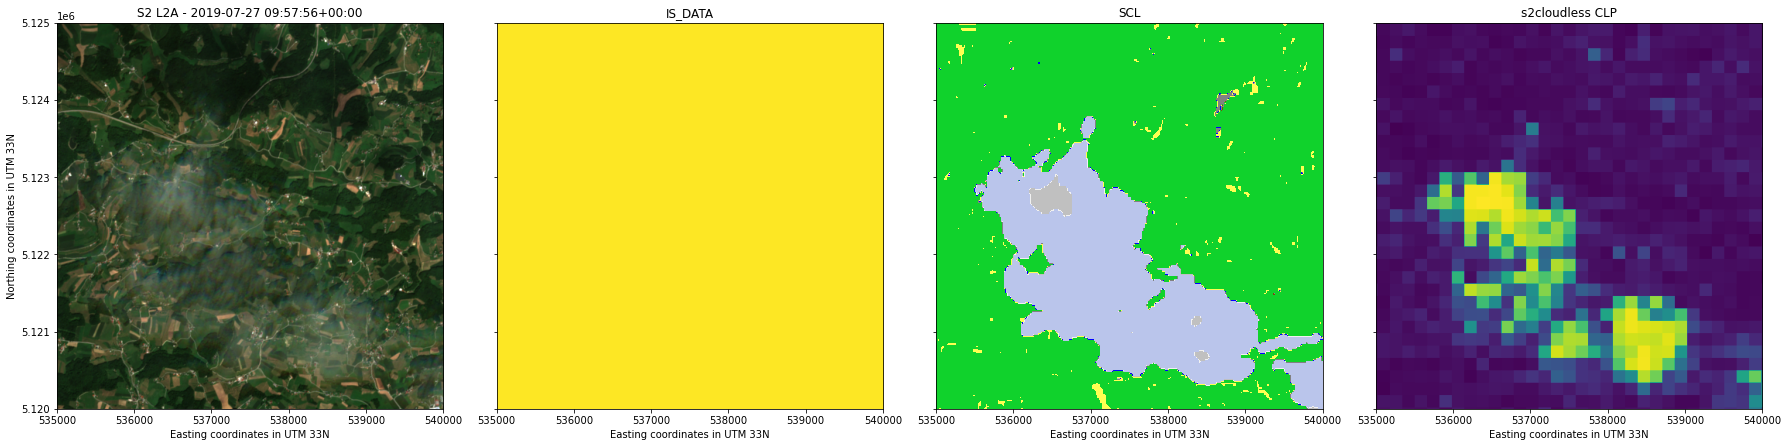

In [17]:
# choose one time index from [0..37] to visualise
tidx = 28

vis_factor = 3.5

norm_factor = s2_l2a_eop.scalar['NORM_FACTORS'][tidx]

fig, axs = plt.subplots(figsize=(25, 6), ncols=4, sharey=True)

axs[0].imshow(vis_factor * norm_factor * s2_l2a_eop.data['BANDS'][tidx][..., [3, 2, 1]],
              extent=get_extent(s2_l2a_eop))
axs[0].set_title(f'S2 L2A - {s2_l2a_eop.timestamp[tidx]}')
axs[0].set_ylabel(f'Northing coordinates in UTM 33N')
axs[0].set_xlabel(f'Easting coordinates in UTM 33N')

axs[1].imshow(s2_l2a_eop.mask['IS_DATA'][tidx].squeeze(), 
              vmin=0, vmax=1, extent=get_extent(s2_l2a_eop))
axs[1].set_title('IS_DATA')
axs[1].set_xlabel(f'Easting coordinates in UTM 33N')

axs[2].imshow(s2_l2a_eop.mask['SCL'][tidx].squeeze(), 
              extent=get_extent(s2_l2a_eop), 
              cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11)
axs[2].set_title('SCL')
axs[2].set_xlabel(f'Easting coordinates in UTM 33N')

axs[3].imshow(s2_l2a_eop.data['CLP'][tidx].squeeze()/255, vmin=0, vmax=1,
              extent=get_extent(s2_l2a_eop))
axs[3].set_title('s2cloudless CLP')
axs[3].set_xlabel(f'Easting coordinates in UTM 33N')

plt.tight_layout();

The information in the provided masks can be used to mask out invalid frames containing clouds/snow/fog. Below is an example using `IS_DATA` and `CLM` mask to find the percentage of valid data in the 6-months period.

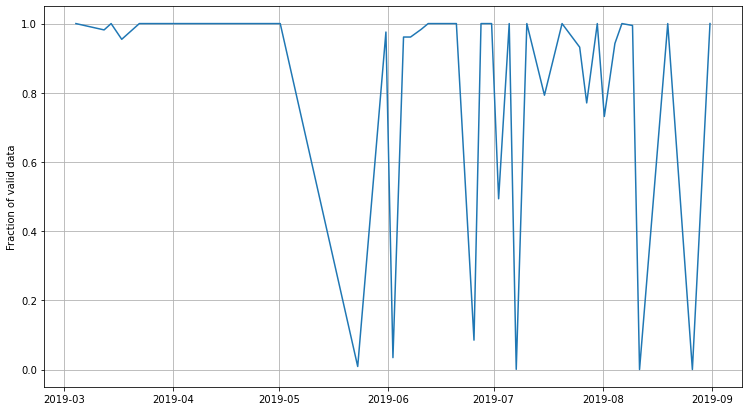

In [18]:
valid_data = np.mean(s2_l2a_eop.mask['IS_DATA'] & ~s2_l2a_eop.mask['CLM'], 
                     axis=(1,2,3)) 

fig, ax = plt.subplots(figsize=(12.5, 7))
ax.plot(s2_l2a_eop.timestamp, valid_data)
ax.set_ylabel('Fraction of valid data')
ax.grid();

Number of frames for this EOPatch with a fraction of valid data greater than 90%. The `SCL` mask and `CLP` masks can be similarly used to estimate data validity fractions.

In [19]:
np.sum(valid_data > .9)

28

### 1.3 Reference polygons <a name="reference"></a>

Now that we have the Sentinel-2 time-series data, time to add the information about the target _cultivated land_ map. This mask is derived from a combination of a _land cover_ dataset and a _declared crops_ dataset.

The reference data is stored as polygons in a GeoDB table. The following task retrieves the polygons within each bounding box defined above.

In [20]:
get_polys = GeoDBVectorImportTask(
    feature=(FeatureType.VECTOR_TIMELESS, 'REFERENCE'), 
    geodb_client=client, 
    geodb_collection='ai4eo_reference',
    geodb_db=GEODB_DATABASE
)

Execute the task and create a new `VECTOR_TIMELESS` feature holding the polygons as a `geopandas` dataframe.

In [21]:
eop = get_polys.execute(eopatch=s2_l2a_eop)

In [22]:
eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=9134, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((535000.0, 5120000.0), (540000.0, 5125000.0)), crs=CRS('32633'))
  timest

In [23]:
eop.vector_timeless['REFERENCE'].head()

,id,created_at,modified_at,geometry,label
0,1,2021-05-31T10:04:13.581432+00:00,None,"POLYGON ((535673.003 5120775.870, 535670.959 5...",1
1,2,2021-05-31T10:04:13.581432+00:00,None,"POLYGON ((539884.010 5120908.653, 539886.566 5...",1
2,3,2021-05-31T10:04:13.581432+00:00,None,"POLYGON ((538224.121 5120243.639, 538224.941 5...",1
3,4,2021-05-31T10:04:13.581432+00:00,None,"POLYGON ((535000.000 5120840.557, 535006.613 5...",1
4,5,2021-05-31T10:04:13.581432+00:00,None,"POLYGON ((539813.339 5120689.620, 539805.008 5...",1


Each polygon has a `label` attribute which denotes its land cover. Values between 1 and 30 denote _agricultural land_ including grassland and meadows, values above 1000 denote land cover types like _water_, _forest_ and _build-up_ area, while the label 100 denotes _agricultural land_ of which the crop-type is unknown.

In [24]:
eop.vector_timeless['REFERENCE'].label.unique()

array([   1,    2,    3,    4,    5,    6,    7,    9,   10,   12,   13,
         16,   18,   21,   27,   30,  100, 1410, 1420, 1500, 1600, 2000,
       3000, 7000])

In [25]:
df = eop.vector_timeless['REFERENCE']

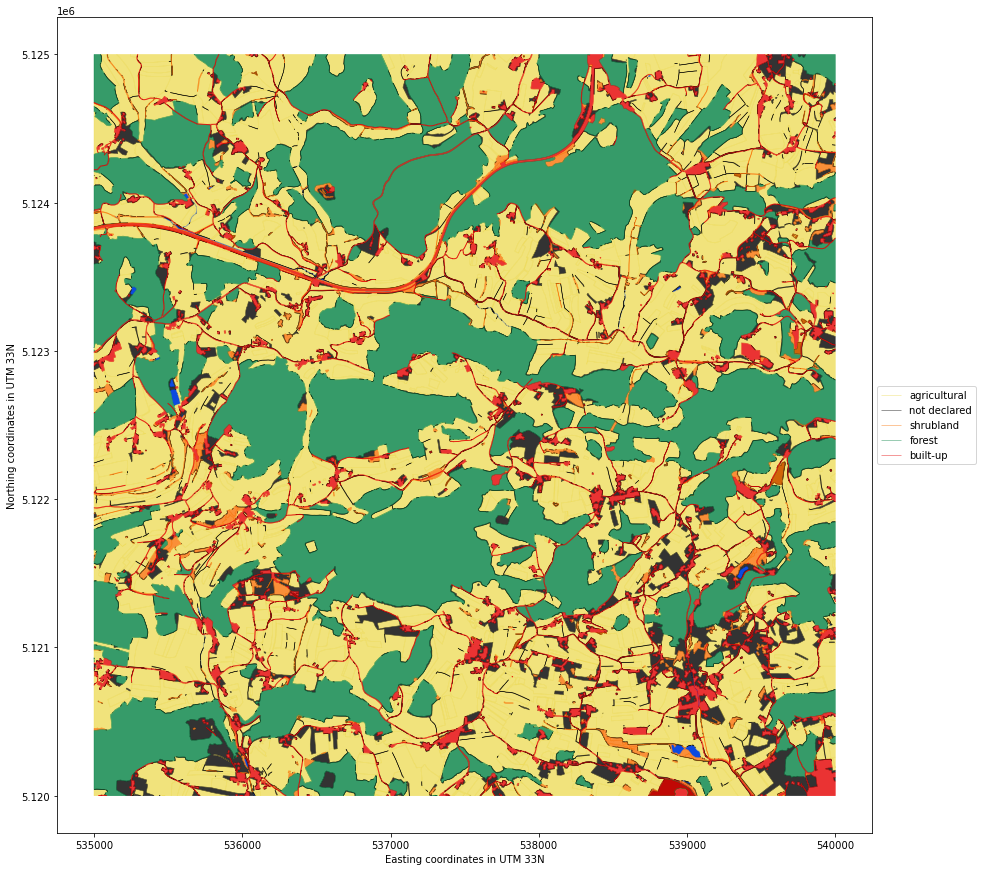

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))

df.query('label<=30').plot(ax=ax, color='xkcd:dull yellow', alpha=.8)
df.query('label<=30').boundary.plot(ax=ax, color='xkcd:dull yellow',
                                    alpha=.8, linewidth=.5, label='agricultural')

df.query('label==100').plot(ax=ax, color='xkcd:black', alpha=.8)
df.query('label==100').boundary.plot(ax=ax, color='xkcd:black',
                                     alpha=.8, linewidth=.5, label='not declared')

df.query('(label>1000) and (label<2000)').plot(ax=ax, color='xkcd:orange', alpha=.8);
df.query('(label>1000) and (label<2000)').boundary.plot(ax=ax, color='xkcd:orange',
                                                        alpha=.8, linewidth=.5, label='shrubland')

df.query('label==2000').plot(ax=ax, color='xkcd:jungle green', alpha=.8)
df.query('label==2000').boundary.plot(ax=ax, color='xkcd:jungle green',
                                      alpha=.8, linewidth=.5, label='forest')

df.query('label==3000').plot(ax=ax, color='xkcd:red', alpha=.8);
df.query('label==3000').boundary.plot(ax=ax, color='xkcd:red', alpha=.8,
                                      linewidth=.5, label='built-up')

# # no values in this EOPatch
# df.query('(label>4000) and (label<=5000)').plot(ax=ax, color='xkcd:bright teal', alpha=.8)
# df.query('(label>4000) and (label<=5000)').plot(ax=ax, color='xkcd:bright teal', alpha=.8,
#                                                 linewidth=.5, label='wetland')

# # no values in this EOPatch
# df.query('label==6000').plot(ax=ax, color='xkcd:grey', alpha=.8)
# df.query('label==6000').plot(ax=ax, color='xkcd:grey', alpha=.8, linewidth=.5, label='bareland')

df.query('label==7000').plot(ax=ax, color='xkcd:blue', alpha=.8)
df.query('label==7000').plot(ax=ax, color='xkcd:blue', alpha=.8, linewidth=.5, label='water')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel(f'Northing coordinates in UTM 33N')
ax.set_xlabel(f'Easting coordinates in UTM 33N');

Names of labels and labels mapping to a binary _cultivated/not-cultivated_ mask are provided in the `json` files in the `metadata` folder. 

In the context of this challenge, _cultivated land_ denotes arable land that is typically worked by ploughing, sowing and raising crops.

In [27]:
with open('metadata/cultivated-mapping.json') as jfile:
    cultivated_mapping = {int(k): v for k, v in json.load(jfile).items()}

Labels that will be mapped to _non-cultivated land_. These labels are a union of _agricultural land_ that is **not** cultivated, e.g. grassland/meadows, tree plantations, greenhouses, and _land covers_ that are not _agricultural land_, e.g. build-up area, water, forest, shrubland.

In [28]:
print(cultivated_mapping[0])

[1, 5, 12, 24, 26, 27, 29, 30, 1410, 1420, 1500, 1600, 1800, 2000, 3000, 4100, 4210, 4220, 5000, 6000, 7000]


Labels that will be mapped to _cultivated land_.

In [29]:
print(cultivated_mapping[1])

[2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28]


Special class which denotes agricultural land that is **not** declared as a specific _cultivated land_. These pixels will have similarities to _cultivated land_, although information is missing about the exact parcel features. For this reason, these polygons will have a weight of `0` and therefore will **not** be used to compute the validation metrics.

In [30]:
print(cultivated_mapping[2])

100


Display names of crops and land cover for each label.

In [31]:
with open('metadata/label-names.json') as jfile:
    label_names = {int(k): v for k, v in json.load(jfile).items()}

_Not-cultivated land_.

In [32]:
for ncl in cultivated_mapping[0]:
    prefix = 'Crop-types' if ncl < 100 else 'Land cover'
    print(f'{prefix} for label {ncl}:')
    print(label_names[ncl])
    print()

Crop-types for label 1:
['grass for seed production', 'grass', 'grass - clover mixture', 'meadow', 'clover-grass mixture', 'clover - grass mixture']

Crop-types for label 5:
['clover', 'clover', 'alfalfa', 'alfalfa', 'Persian clover']

Crop-types for label 12:
['land lying fallow', 'grass carpet roll']

Crop-types for label 24:
['crimson clover']

Crop-types for label 26:
['olive tree']

Crop-types for label 27:
['common grape vine for production of wine', 'common grape vine for human consumption (table grape)', 'grape vine, normally not for consumption']

Crop-types for label 29:
['strawberry']

Crop-types for label 30:
['not in use', 'border fence', "the plant is not in contact with the earth's soil", 'apple tree', 'pear tree', 'quince tree', 'pomegranate tree', 'medlar tree', 'jujube tree', 'peach tree', 'nectarine tree', 'plum tree', 'apricot tree', 'cherry tree', 'sour cherry tree', 'common walnut tree', 'hazel shrub', 'almond tree', 'kiwifruit tree', 'persimmon tree', 'chestnut t

_Cultivated land_

In [33]:
for cl in cultivated_mapping[1]:
    prefix = 'Crop-types' if cl < 100 else 'Land cover'
    print(f'{prefix} for label {cl}:')
    print(label_names[cl])
    print()

Crop-types for label 2:
['maize for grain', 'maize for silage', 'sorghum', 'sweet corn', 'sorghum for fodder', 'sudan grass']

Crop-types for label 3:
['winter wheat', 'winter rye', 'winter spelt', 'winter triticale', 'winter oat', 'winter cereals', 'mixture of winter wheat and winter rye', 'winter durum wheat', 'winter khorasan wheat']

Crop-types for label 4:
['winter barley']

Crop-types for label 6:
['pumpkin for seed oil']

Crop-types for label 7:
['radicchio for fodder', 'mixture of vegetables for human consumption', 'various permanent herbs', 'annual herbs', 'mixture of vegetables, herbs and other crops', 'mixture of vegetables for human consumption under 0,1 hectare', 'asparagus', 'mixture of vegetables and other crops for snail farming', 'artichoke']

Crop-types for label 8:
['winter rapeseed for fodder', 'winter rapeseed']

Crop-types for label 9:
['summer wheat', 'summer rye', 'summer spelt', 'summer triticale', 'summer oat', 'summer barley', 'summer cereals', 'summer durum 

**NOTE:** although these labels are mapped to a binary mask for training, you can use label information for sampling of pixels and image chips.

**NOTE:** there is a very small number of polygons where crop declarations disagree with the land cover information, i.e. there is a declared cultivated land where the land cover indicates it is not agricultural. We leave the choice to you on how to deal with these polygons, e.g. whether to consider them as _cultivated_ or _not-cultivated_.

Now we can rasterize the reference labels, to allow further processing and model training. **The reference polygons are rasterised at the target spatial resolution of 2.5m**, resulting in a `4x` spatial enhancement. 

Three masks are added to the `EOPatch`:

 * `CULTIVATED`: this mask is the target output used in training and testing of your method;
 * `NOT_DECLARED`: this mask marks pixels that are ignored in the calculation of the validation metrics;
 * `ALL_POLYS`: all polygons are rasterised with a given `label`. Use this to customise your sampling given land cover and crop-type information.
 
A negative buffer of 2.5m is applied prior to rasterisation, in order to single out neighbouring touching polygons.

In [34]:
MAP_RESOLUTION = 2.5 # metres

In [35]:
valid_polys_to_mask = VectorToRaster(
    (FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
    (FeatureType.MASK_TIMELESS, 'CULTIVATED'),
    values=cultivated_mapping[1],
    values_column='label',
    raster_resolution=MAP_RESOLUTION,
    raster_dtype=np.uint8,  
    all_touched=False,
    buffer=-MAP_RESOLUTION  # DO NOT CHANGE THIS BUFFER
)

invalid_polys_to_mask = VectorToRaster(
    (FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
    (FeatureType.MASK_TIMELESS, 'NOT_DECLARED'),
    values=cultivated_mapping[2],
    values_column='label',
    raster_resolution=MAP_RESOLUTION,
    raster_dtype=np.uint8,
    all_touched=False,
    buffer=-MAP_RESOLUTION  # DO NOT CHANGE THIS BUFFER
)

all_polys_to_mask = VectorToRaster(
    (FeatureType.VECTOR_TIMELESS, 'REFERENCE'),
    (FeatureType.MASK_TIMELESS, 'ALL_POLYS'),
    values=None,
    values_column='label',
    raster_resolution=MAP_RESOLUTION,
    raster_dtype=np.uint16,
    all_touched=False,
    buffer=-MAP_RESOLUTION  # you can modify this buffer
)

In [36]:
eop = valid_polys_to_mask.execute(eop)
eop = invalid_polys_to_mask.execute(eop)
eop = all_polys_to_mask.execute(eop)

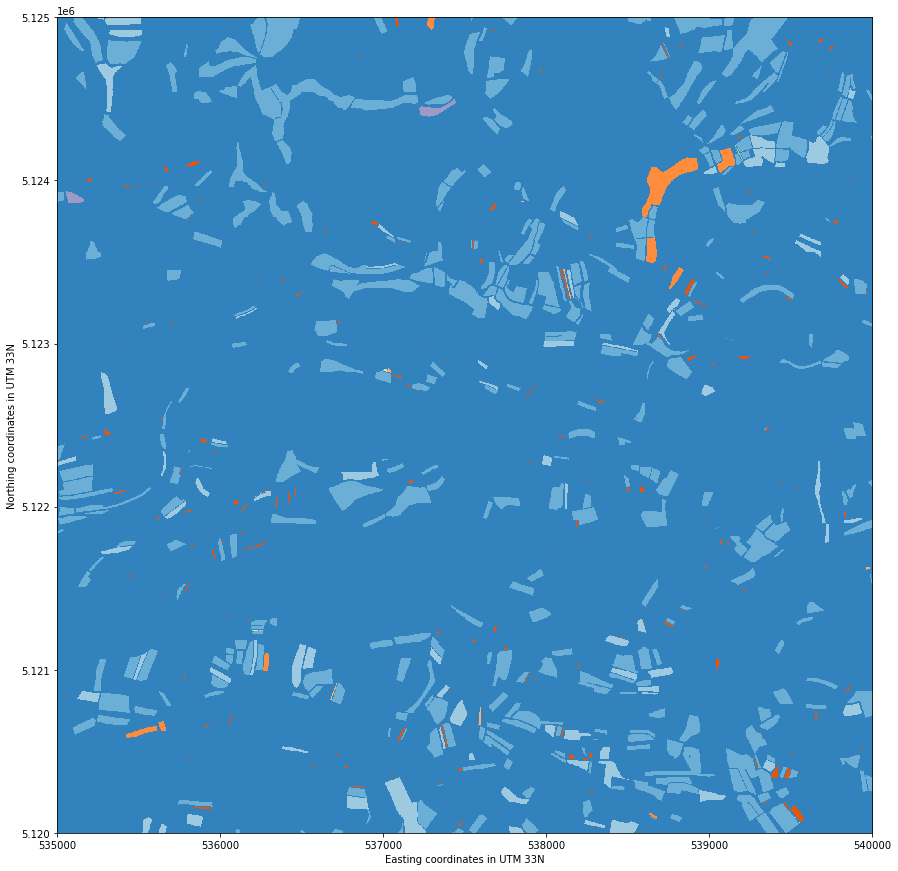

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(eop.mask_timeless['CULTIVATED'].squeeze(), 
          vmin=0, vmax=30, extent=get_extent(eop), 
          interpolation='nearest', cmap=plt.cm.tab20c)
ax.set_ylabel(f'Northing coordinates in UTM 33N')
ax.set_xlabel(f'Easting coordinates in UTM 33N');

The above tasks rasterise polygons assigning to pixels their `label` values. We add a task that turns the `CULTIVATED` and `NOT_DECLARED` masks into binary masks. 

In [38]:
class ToBinaryTask(EOTask):
    """ Turn a discrete feature to a binary mask """
    def __init__(self, feature: Tuple[FeatureType, str]):
        """ 
        :param feature: Feature in eopatch to binarise 
        """
        self.feature = feature
        
    def execute(self, eopatch: EOPatch) -> EOPatch:
        """ Overwrite existing feature with binary mask """
        eopatch[self.feature] = eopatch[self.feature] > 0
        return eopatch

In [39]:
valid_to_binary = ToBinaryTask((FeatureType.MASK_TIMELESS, 'CULTIVATED'))
invalid_to_binary = ToBinaryTask((FeatureType.MASK_TIMELESS, 'NOT_DECLARED'))

In [40]:
eop = valid_to_binary.execute(eop)
eop = invalid_to_binary.execute(eop)

In [41]:
eop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=9134, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seco

Display target binary _cultivated land_ map, overlayed with the original polygons.

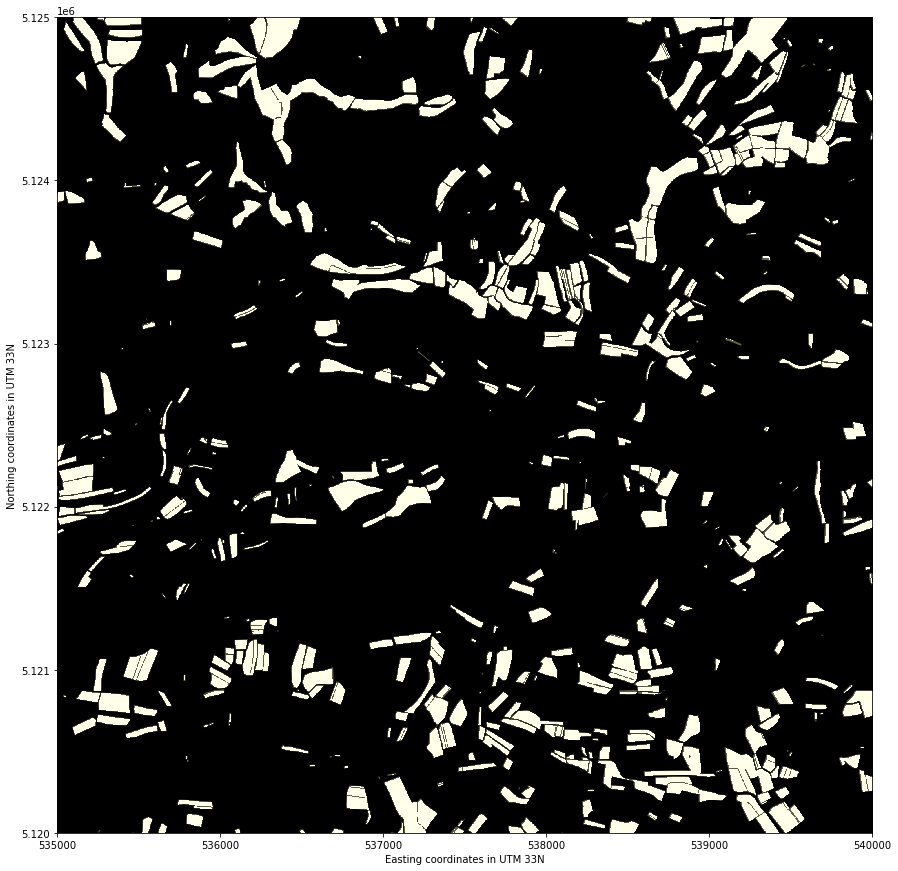

In [42]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(eop.mask_timeless['CULTIVATED'], 
          interpolation='nearest', 
          cmap=plt.cm.binary_r, extent=get_extent(eop))
df[df.label.isin(cultivated_mapping[1])].plot(ax=ax, 
                                              color='xkcd:ivory', 
                                              alpha=.4, 
                                              linewidth=.5)

ax.set_ylabel(f'Northing coordinates in UTM 33N')
ax.set_xlabel(f'Easting coordinates in UTM 33N');

### 1.4 Training data download <a name="train-data"></a>

We can now create a workflow that downloads and processes the training data as shown above, and parallelize the workflow over the 100 training bounding boxes.

In [43]:
# change this path accordingly to your set-up
EOPATCHES_PATH = 'eopatches'
EOPATCHES_TRAIN_PATH = f'{EOPATCHES_PATH}/train/'
EOPATCHES_TEST_PATH = f'{EOPATCHES_PATH}/test/'

if not os.path.exists(EOPATCHES_TRAIN_PATH):
    os.makedirs(EOPATCHES_TRAIN_PATH, exist_ok=True)

if not os.path.exists(EOPATCHES_TEST_PATH):
    os.makedirs(EOPATCHES_TEST_PATH, exist_ok=True)

Task to save the `EOPatch`es to disk for further processing.

In [44]:
save = SaveTask(path=EOPATCHES_PATH, compress_level=2)

The previous steps are combined into a linear workflow, performing S2 data download, adding the reference polygons, rasterising the polygons to rasters, creating binary masks and saving the eopatches to disk.

In [45]:
workflow = LinearWorkflow(get_s2_l2a, 
                          get_polys, 
                          valid_polys_to_mask,
                          invalid_polys_to_mask,
                          all_polys_to_mask,
                          valid_to_binary,
                          invalid_to_binary, 
                          save)

In [46]:
execution_args = []

for irow, row in tqdm(bboxes.iterrows(), total=len(bboxes)):
    bbox = BBox(row.geometry, crs=CRS(bboxes.crs))
    eopatch_folder = f'train/eopatch-{row.eop_index}'
    
    eop_exec_args = {
        get_s2_l2a: {
            'bbox': bbox,
            'time_interval': S2_TIME_INTERVAL
        },
        save: {
            'eopatch_folder': eopatch_folder
        }
    }
    
    execution_args.append(eop_exec_args)


  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
execution_args[:3]

[{<eolearn.io.sentinelhub_process.SentinelHubInputTask at 0x7fe57fb49a90>: {'bbox': BBox(((535000.0, 5120000.0), (540000.0, 5125000.0)), crs=CRS('32633')),
   'time_interval': ('2019-03-01', '2019-09-01')},
  <eolearn.core.core_tasks.SaveTask at 0x7fe57c449040>: {'eopatch_folder': 'train/eopatch-738'}},
 {<eolearn.io.sentinelhub_process.SentinelHubInputTask at 0x7fe57fb49a90>: {'bbox': BBox(((590000.0, 5170000.0), (595000.0, 5175000.0)), crs=CRS('32633')),
   'time_interval': ('2019-03-01', '2019-09-01')},
  <eolearn.core.core_tasks.SaveTask at 0x7fe57c449040>: {'eopatch_folder': 'train/eopatch-905'}},
 {<eolearn.io.sentinelhub_process.SentinelHubInputTask at 0x7fe57fb49a90>: {'bbox': BBox(((565000.0, 5145000.0), (570000.0, 5150000.0)), crs=CRS('32633')),
   'time_interval': ('2019-03-01', '2019-09-01')},
  <eolearn.core.core_tasks.SaveTask at 0x7fe57c449040>: {'eopatch_folder': 'train/eopatch-838'}}]

Parallelise the workflow over the workers. Change `NUM_WORKERS` according to your set-up.

In [ ]:
NUM_WORKERS = 4

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=NUM_WORKERS)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

**NOTE:** now that all data has been saved to disk, there is no need to run the code above for download. To read the `EOPatch`es, simply use the `LoadTask` as follows.

In [50]:
load = LoadTask(path=EOPATCHES_PATH)

In [96]:
eop_rand = bboxes.sample(n=1).iloc[0]

eop_folder = f'train/eopatch-{eop_rand.eop_index}'

reop = load.execute(eopatch_folder=eop_folder)

In [97]:
reop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=3042, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seco

### 1.5 Testing data download <a name="test-data"></a>

The code above showed how to retrieve data to be used to train your algorithms. The data used to test and evaluate your algorithm is instead provided as a single compressed file to download. Check the main webpage to find the link to download the file (appr. 2.7GB).

This is done to anonymize the location of the test areas. Such 25 test areas have been taken from Slovenia and from neighbouring countries. The distribution of bands, labels and underlying cultivated land for the test areas matches the distributions of the train areas. 

The test EOPatches are named as `eopatch-01` to `eopatch-25`, and have been assigned random spatial coordinates all over UTM 33N. The EOPatches contain only information about the bands, clouds and scene classification masks. The aim of the challenge is to predict and submit a binary _cultivated land_ map at 2.5m for these 25 test areas. 

The following extracts the downloaded `test-eopatches.tar.gz` file in the `test` subfolder of our `EOPATCHES_PATH` directory.

In [ ]:
# !tar -xvzf test-eopatches.tar.gz {EOPATCHES_PATH}/test/

In [72]:
!ls {EOPATCHES_PATH}/test/

eopatch-01  eopatch-06	eopatch-11  eopatch-16	eopatch-21
eopatch-02  eopatch-07	eopatch-12  eopatch-17	eopatch-22
eopatch-03  eopatch-08	eopatch-13  eopatch-18	eopatch-23
eopatch-04  eopatch-09	eopatch-14  eopatch-19	eopatch-24
eopatch-05  eopatch-10	eopatch-15  eopatch-20	eopatch-25


In [75]:
eops_test = sorted(os.listdir(f'{EOPATCHES_PATH}/test/'))

Let's look at the content of a test `EOPatch`

In [77]:
teop = load.execute(eopatch_folder=f'test/eopatch-01')

teop

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((675900.0, 898600.0), (680900.0, 903600.0)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2019, 3, 4, 10, 6, 2, tzinfo=tzlocal()), ...], length=38
)

### 1.6 Files check <a name="files-check"></a>

Whether you downloaded the training data through the APIs or direct link, best to check that all data has been correctly retrieved.

The same applies for the test data downloaded through direct link.

The following code encodes each downloaded numpy file as MD5 hash and compares them to the target MD5 hashes provided in the `metadata` folder. It should take a few minutes to compute.

In [68]:
train_md5_hashes = md5_encode_files(f'{EOPATCHES_PATH}/train')

  0%|          | 0/900 [00:00<?, ?it/s]

In [69]:
test_md5_hashes = md5_encode_files(f'{EOPATCHES_PATH}/test')

  0%|          | 0/150 [00:00<?, ?it/s]

If the following fails, there are some issues with the downloaded files.

In [70]:
assert train_md5_hashes.equals(pd.read_csv('metadata/hashed-md5-train-files.csv', 
                                           usecols=['filename', 'hash']))

In [71]:
assert test_md5_hashes.equals(pd.read_csv('metadata/hashed-md5-test-files.csv', 
                                          usecols=['filename', 'hash']))

## 2. Validation Metric <a name="validation-metric"></a>

This section reports how the validation metric is computed, to allow you to implement the same logic when optimising your algorithm.

The metric is a weighted version of the [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient). 

The following functions shows how the weight map is obtained from the `CULTIVATED` and `NOT_DECLARED` masks. The idea behind this weighting scheme is to provide more weight, e.g. relevance, to small parcels, and to the contouring background that singles them out. Ideally, your algorithm should be able to classify and recover all parcels, in particular the smaller ones since they are the most challenging.

In [79]:
%matplotlib inline

from scipy.stats import skewnorm

from skimage import measure
from skimage.morphology import binary_dilation, disk

In [95]:
def weighting_function(pix_size: int, median_pix_size: int, highest_weight_pix_size: int = 35,
                       skewness: int = 15) -> float:
    """ Creates weight to be applied to a parcel depending on its number of pixels (after pixelation) """
    if pix_size >= median_pix_size:
        return 1
    
    xs = np.linspace(1, median_pix_size, median_pix_size)
    y1 = skewnorm.pdf(xs, skewness, loc=highest_weight_pix_size-100/3.14, scale=100)
    y1 = y1 / max(y1)
    y1 = y1 + 1

    return y1[int(pix_size)].astype(np.float)


class AddWeightMapTask(EOTask):
    """ Computes the weight map used to compute the validation metric """

    def __init__(self, 
                 cultivated_feature: Tuple[FeatureType, str], 
                 not_declared_feature: Tuple[FeatureType, str], 
                 weight_feature: Tuple[FeatureType, str], 
                 radius: int = 2, seed: int = 4321):
        self.cultivated_feature = cultivated_feature
        self.not_declared_feature = not_declared_feature
        self.weight_feature = weight_feature
        self.radius = radius
        self.seed = seed
        
    def execute(self, eopatch: EOPatch) -> EOPatch:
        cultivated = eopatch[self.cultivated_feature].astype(np.uint8).squeeze()
        not_declared = eopatch[self.not_declared_feature].squeeze()

        np.random.seed(self.seed)

        # compute connected components on binary mask
        conn_comp = measure.label(cultivated, background=0)
        # number of connected components
        n_comp = np.max(conn_comp) + 1

        # Placeholder for outputs
        height, width = cultivated.shape
        weights = np.zeros((height, width), dtype=np.float32)
        contours = np.zeros((height, width), dtype=np.float32)
        counts = np.zeros((height, width), dtype=np.uint8)

        # Loop over connected components, ignoring background
        for ncc in tqdm(np.arange(1, n_comp)):
            parcel_mask = conn_comp == ncc
            # number of pixels of each component, i.e. parcel
            n_pixels = np.sum(parcel_mask)

            # compute external boundary of parcel 
            dilated_mask = binary_dilation(parcel_mask, selem=disk(radius=self.radius))
            contour = np.logical_and(~parcel_mask, dilated_mask)

            weight = weighting_function(n_pixels, median_pix_size=400)

            weights[parcel_mask] = weight
            contours += 2 * weight * contour
            # In case countours overlap, the average weight is taken
            counts += contour

        # combine weights from all parcels into a single map. First add (averaged) contours,
        # then weighted parcels, then background 
        weight_map = np.zeros((height, width), dtype=np.float32)
        weight_map[contours > 0] = contours[contours > 0] / counts[contours > 0]
        weight_map[weights > 0] = weights[weights > 0]
        weight_map[weight_map == 0] = 1

        # add zero weights at border and undeclared parcels
        weight_map[not_declared == True] = 0
        weight_map[:1, :] = 0
        weight_map[:, :1] = 0
        weight_map[-2:, :] = 0
        weight_map[:, -2:] = 0

        eopatch[self.weight_feature] = weight_map[..., np.newaxis]
        
        return eopatch
        

The weighting functions is defined as follows:

 * `w=1`, if label is `1` and number of pixels is larger than the median, where the median is 400
 * `w=1`, if label is `0`, e.g. background
 * `w=0`, if `NOT_DECLARED` mask is `True`
 * otherwise, a skewed normal distribution as a function of the number of pixels is returned, as shown below.
 
The weight map is computed as follows:

`SCORE_WEIGHT = (cultivated*weight) + (2*contours*weight)`

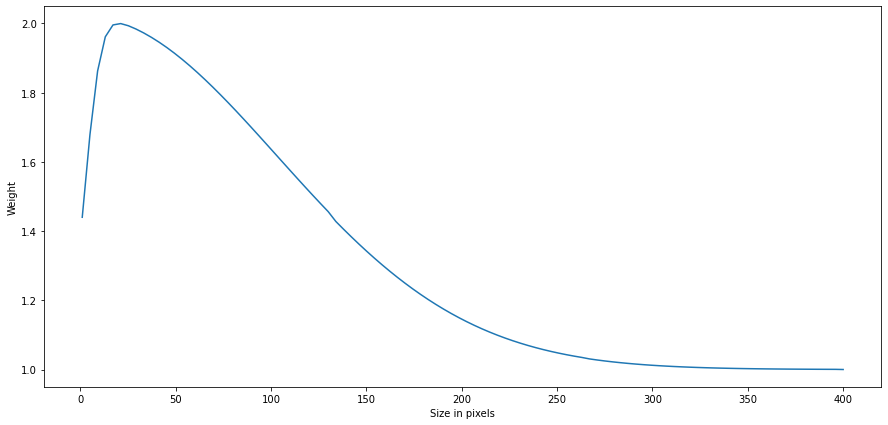

In [100]:
xs = np.linspace(1, 400, 100)
ys = [weighting_function(x, median_pix_size=400) for x in xs]

fig , ax = plt.subplots(figsize=(15, 7))
ax.plot(xs, ys)
ax.set_xlabel('Size in pixels')
ax.set_ylabel('Weight');

In [98]:
add_weight = AddWeightMapTask(
    (FeatureType.MASK_TIMELESS, 'CULTIVATED'), 
    (FeatureType.MASK_TIMELESS, 'NOT_DECLARED'),
    (FeatureType.DATA_TIMELESS, 'WEIGHTS')
)

In [99]:
reop = add_weight.execute(reop)
reop

  0%|          | 0/1022 [00:00<?, ?it/s]

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {
    WEIGHTS: numpy.ndarray(shape=(2000, 2000, 1), dtype=float32)
  }
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=3042, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size

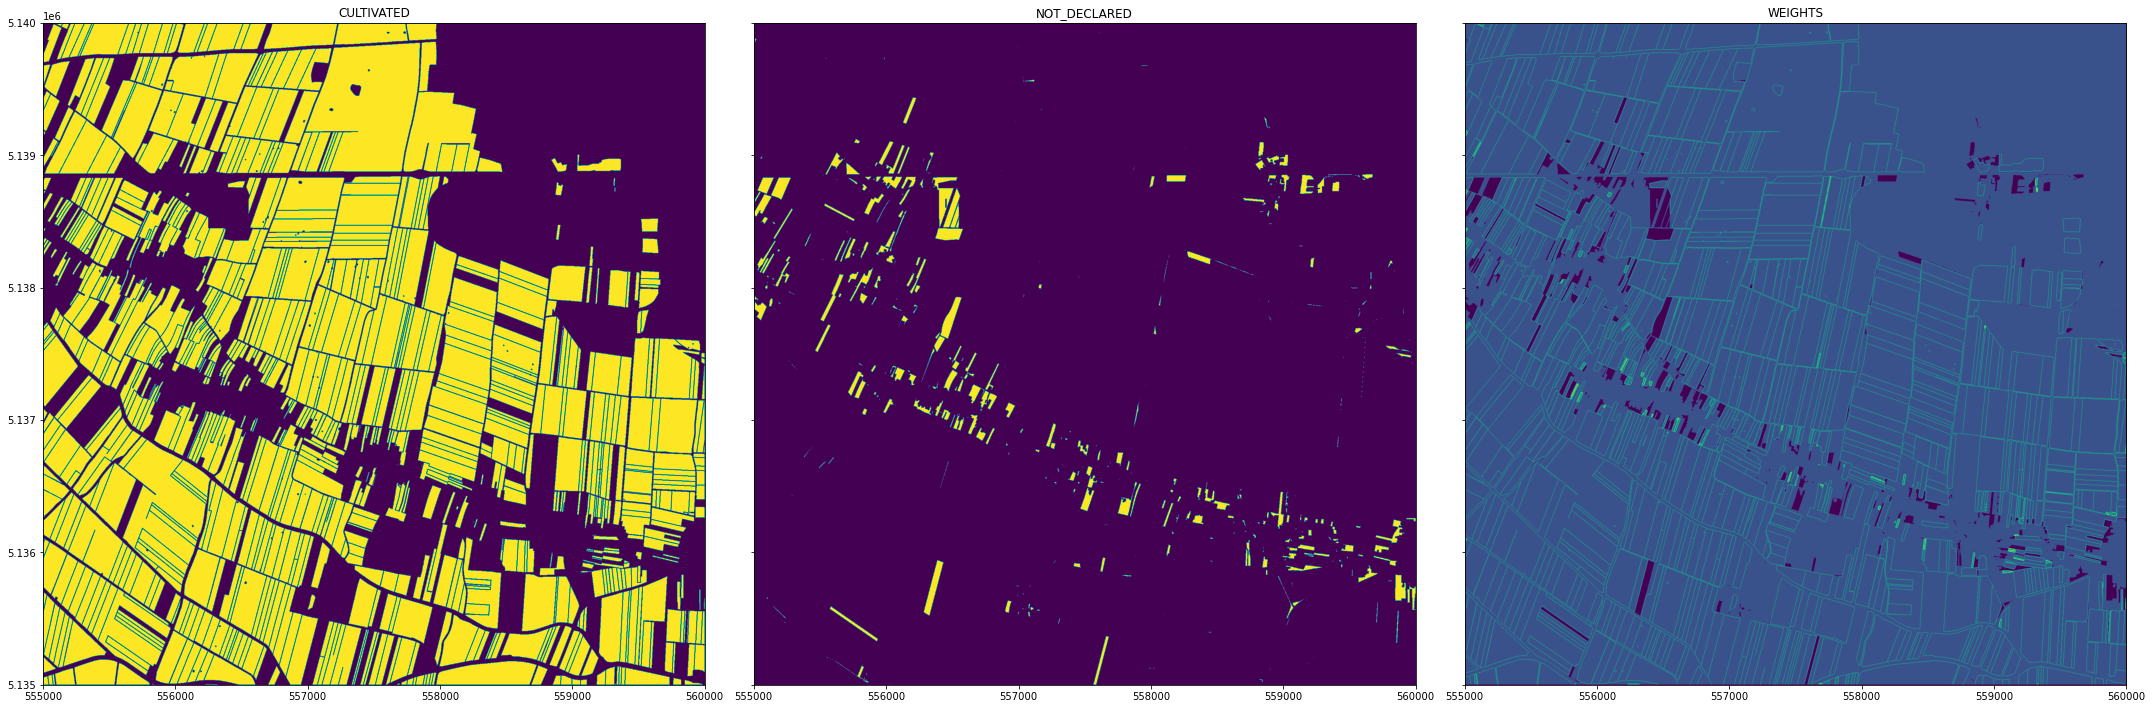

In [104]:
fig, axs = plt.subplots(figsize=(30, 10), ncols=3, sharey=True)

axs[0].imshow(reop.mask_timeless['CULTIVATED'].squeeze(), vmin=0, vmax=1, extent=get_extent(reop))
axs[0].set_title('CULTIVATED')

axs[1].imshow(reop.mask_timeless['NOT_DECLARED'].squeeze(), vmin=0, vmax=1, extent=get_extent(reop))
axs[1].set_title('NOT_DECLARED')

axs[2].imshow(reop.data_timeless['WEIGHTS'].squeeze(), vmin=0, vmax=4, extent=get_extent(reop))
axs[2].set_title('WEIGHTS')

plt.tight_layout();

You can loop over your training EOPatches and add the weight map.

Once you aggregate the values for reference (e.g. `y_true`), predicted (e.g. `y_pred`) and weights (e.g. `sample_weight`) arrays, you can compute the metric as follows

```python
from sklearn.metrics import matthews_corrcoef

score = matthews_corrcoef(y_true, y_pred, sample_weight=sample_weight)
```

## 3. Data Processing <a name="data-processing"></a>

This section offers some tips and pointers on how to possibly transform the data in a ML-ready format.

Possible steps are:

 * filter out invalid timestamps due to clouds/shadows/snow;
 * sample or generate the same number of S2 timestamps for all EOPatches;
 * sample smaller image chips from S2 time-series with corresponding target binary _cultivated land_ map.
 
If you want to use `eo-learn` for these tasks, check out the documentation about existing tasks like filtering and pixel sampling [here](https://eo-learn.readthedocs.io/en/latest/eotasks.html). You can easily implement your own task (as done above) by following [this example](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOTask). [Here](https://github.com/sentinel-hub/eo-learn/tree/master/examples) you can find a collection of examples including land cover and crop-type classification.

Below we provide a custom task to sample patchlets/image chips from the Sentinel-2 time-series and the reference map.

In [105]:
class SamplePatchletsTask(EOTask):

    SCALE_FACTOR = 4

    def __init__(self, s2_patchlet_size: int, num_samples: int):
        """ Set-up of task 
        
        :param s2_patchlet_size: Size in pixels of resulting patchlet
        :param num_samples: Number of patchlets to sample
        """
        self.s2_patchlet_size = s2_patchlet_size
        self.num_samples = num_samples

    def _calculate_sampled_bbox(self, bbox: BBox, r: int, c: int, s: int,
                                resolution: float) -> BBox:
        """ Calculate bounding box of smaller patchlets """
        return BBox(((bbox.min_x + resolution * c,  bbox.max_y - resolution * (r + s)),
                     (bbox.min_x + resolution * (c + s), bbox.max_y - resolution * r)),
                    bbox.crs)

    def _sample_s2(self, eop: EOPatch, row: int, col: int, size: int, 
                   resolution: float = 10):
        """ Randomly sample a patchlet from the EOPatch """
        # create a new eopatch for each sub-sample
        sampled_eop = EOPatch(timestamp=eop.timestamp, 
                              scalar=eop.scalar, 
                              meta_info=eop.meta_info)
        
        # sample S2-related arrays
        features = eop.get_feature_list()
        s2_features = [feature for feature in features 
                       if isinstance(feature, tuple) and 
                       (feature[0].is_spatial() and feature[0].is_time_dependent())]
        
        for feature in s2_features:
            sampled_eop[feature] = eop[feature][:, row:row + size, col:col + size, :]
        
        # calculate BBox for new sub-sample
        sampled_eop.bbox = self._calculate_sampled_bbox(eop.bbox, 
                                                        r=row, c=col, s=size, 
                                                        resolution=resolution)
        sampled_eop.meta_info['size_x'] = size
        sampled_eop.meta_info['size_y'] = size
        
        # sample from target maps, beware of `4x` scale factor
        target_features = eop.get_feature(FeatureType.MASK_TIMELESS).keys()
        
        for feat_name in target_features:
            sampled_eop.mask_timeless[feat_name] = \
            eop.mask_timeless[feat_name][self.SCALE_FACTOR*row:self.SCALE_FACTOR*row + self.SCALE_FACTOR*size, 
                                         self.SCALE_FACTOR*col:self.SCALE_FACTOR*col + self.SCALE_FACTOR*size]
        
        return sampled_eop

    def execute(self, eopatch_s2: EOPatch, buffer: int=0,  seed: int=42) -> List[EOPatch]:
        """ Sample a number of patchlets from the larger EOPatch. 
        
        :param eopatch_s2: EOPatch from which patchlets are sampled
        :param buffer: Do not sample in a given buffer at the edges of the EOPatch
        :param seed: Seed to initialise the pseudo-random number generator
        """
        _, n_rows, n_cols, _ = eopatch_s2.data['BANDS'].shape
        np.random.seed(seed)
        eops_out = []
        
        # random sampling of upper-left corner. Change this for non-overlapping patchlets
        for patchlet_num in range(0, self.num_samples):
            row = np.random.randint(buffer, n_rows - self.s2_patchlet_size - buffer)
            col = np.random.randint(buffer, n_cols - self.s2_patchlet_size - buffer)
            sampled_s2 = self._sample_s2(eopatch_s2, row, col, self.s2_patchlet_size)
            eops_out.append(sampled_s2)

        return eops_out

In [106]:
sample_task = SamplePatchletsTask(s2_patchlet_size=32, num_samples=4)

In [107]:
samples = sample_task.execute(eop)

In [108]:
len(samples)

4

Let's check a sample

In [109]:
samples[0]

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(38, 32, 32, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(38, 32, 32, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(38, 32, 32, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(38, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(128, 128, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(128, 128, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(128, 128, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 32
    size_y: 32
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 3, 1, 0, 0), datetime.datetime(2019, 9, 1, 23, 59, 59))
  }
  bbox: BBox(((539350.0, 5123660.0), (53

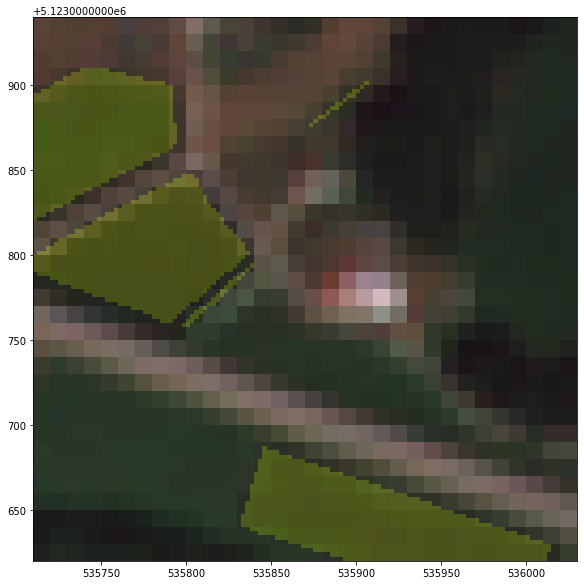

In [110]:
tidx = 28
sample = samples[2]
norm_fact = sample.scalar['NORM_FACTORS'][tidx]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(3.5 * norm_factor * sample.data['BANDS'][tidx][..., [3,2,1]], 
          extent=get_extent(sample))
ax.imshow(sample.mask_timeless['CULTIVATED'].squeeze(), 
          vmin=0, vmax=1, alpha=.2, 
          extent=get_extent(sample));

## 4. Submission Example <a name="submission-example"></a>

A valid submission entails submitting a zipped folder containing a tiff file for each of the 25 test EOPatches at the target **2.5m** resolution, meaning a `2000x2000` pixels binary raster for each test areas.

The `.tif` file should be in the `epsg:32633` coordinate reference system, as the data provided, and should be named as the corresponding `EOPatch`, i.e. `eopatch-01.tif`. Check-out the [`ExportToTiff`](https://eo-learn.readthedocs.io/en/latest/eolearn.io.local_io.html#eolearn.io.local_io.ExportToTiff) task to export a feature to  a tif file. The task uses [rasterio](https://rasterio.readthedocs.io/en/latest/topics/writing.html).

The following code shows how to generate a valid submission using a dummy thresholding method.

### 4.1 Prepare a submission <a name="prepare-a-submission"></a>

The following code shows how to run a simple workflow to export the predicted masks for submission. 

The workflow applies the following:

 * reads `EOPatch` from disk and transforms DNs to reflectances
 * filters timestamps based on `CLM` and `IS_DATA` masks
 * computes NDVI and mean NDVI over the filtered timestamps
 * upscales the mean NDVI to the target spatial resolution of 2.5m
 * applies a thresholding on upscaled mean NDVI
 * exports predicted binary mask
 
The workflow is applied on test EOPatches since they are the only files evaluated.

In your method of course you will make use of the training data to develop a machine learning model, and apply the model to the test patches for the prediction only.

In [111]:
SUBMISSION_DIR = 'submission'

if not os.path.exists(SUBMISSION_DIR):
    os.makedirs(SUBMISSION_DIR)

In [112]:
import cv2

from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.io import ExportToTiff 

In [113]:
class ComputeReflectances(EOTask):
    """ Apply normalisation factors to DNs """
    def __init__(self, feature):
        self.feature = feature
        
    def execute(self, eopatch):
        eopatch[self.feature] = eopatch.scalar['NORM_FACTORS'][..., None, None] \
            * eopatch[self.feature].astype(np.float32)
        return eopatch

class SentinelHubValidData:
    """
    Combine 'CLM' mask with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

    
class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

    
class MeanNDVI(EOTask):
    """
    Compute the mean temporal NDVI
    """
    def __init__(self, ndvi_feature, mean_ndvi_feature):
        self.ndvi_feature = ndvi_feature
        self.mean_ndvi_feature = mean_ndvi_feature
        
    def execute(self, eopatch):
        eopatch[self.mean_ndvi_feature] = np.nanmean(eopatch[self.ndvi_feature], axis=0)
        return eopatch
    

class Enhance(EOTask):
    """
    Upscale S2 to target resolution
    """
    def __init__(self, feature_in, feature_out, scale_factor=4):
        self.feature_in = feature_in
        self.feature_out = feature_out
        self.scale_factor = scale_factor
        
    def execute(self, eopatch):
        array_in = eopatch[self.feature_in]
        if array_in.ndim == 4:
            array_out = np.concatenate([cv2.resize(arr.squeeze(), 
                                                   None,
                                                   fx=self.scale_factor, 
                                                   fy=self.scale_factor, 
                                                   interpolation = cv2.INTER_CUBIC) 
                                        for arr in array_in])
        elif array_in.ndim == 3:
            array_out = cv2.resize(array_in.squeeze(), None, 
                                   fx=self.scale_factor, 
                                   fy=self.scale_factor, 
                                   interpolation = cv2.INTER_CUBIC) 
        eopatch[self.feature_out] = array_out[..., np.newaxis]
        return eopatch
    

class Classify(EOTask):
    """ Threshold mean NDVI mask """
    def __init__(self, feature_in, feature_out, low_cut=-1., high_cut=1.):
        self.feature_in = feature_in
        self.feature_out = feature_out
        self.low_cut = low_cut
        self.high_cut = high_cut
        
    def execute(self, eopatch):
        array_in = eopatch[self.feature_in]
        
        new_eopatch = EOPatch(bbox=eopatch.bbox)
        
        new_eopatch[self.feature_out] = np.logical_and(array_in > self.low_cut, 
                                                       array_in <= self.high_cut).astype(np.uint8)
        return new_eopatch

In [114]:
band_names = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

# LOAD EOPATCH
load = LoadTask(path=EOPATCHES_PATH)

# COMPUTE REFLECTANCES FROM DNs
normalise = ComputeReflectances((FeatureType.DATA, 'BANDS'))

# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), 
                                     (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), 
                                      band_names.index('B04')])

# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = AddValidDataMaskTask(SentinelHubValidData(), 'IS_VALID')

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask('IS_VALID', 'VALID_COUNT')

# FILTER OUT CLOUDY SCENES
# Keep timestamps with > 95% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.95)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# COMPUTE MEAN TEMPORAL NDVI
# Compute mean NDVI values over the time-series
mean_ndvi = MeanNDVI((FeatureType.DATA, 'NDVI'), 
                     (FeatureType.DATA_TIMELESS, 'MEAN_NDVI'))

# UPSCALE MEAN NDVI USING BICUBIC INTERPOLATION
# Apply the 4x upscaling by using bicubic interpolation
enhance = Enhance((FeatureType.DATA_TIMELESS, 'MEAN_NDVI'),
                  (FeatureType.DATA_TIMELESS, 'BIG_MEAN_NDVI'))

# THRESHOLD UPSCALED MEAN NDVI
# Apply thesholds to upscaled mean NDVI
classify = Classify((FeatureType.DATA_TIMELESS, 'BIG_MEAN_NDVI'),
                    (FeatureType.MASK_TIMELESS, 'PREDICTION'),
                    low_cut=.4, high_cut=.6)

# EXPORT PREDICTION AS TIFF
# Export the predicted binary mask as tiff for submission
# NOTE: make sure both 0s and 1s are correctly exported
export = ExportToTiff(feature=(FeatureType.MASK_TIMELESS, 'PREDICTION'),
                      folder=SUBMISSION_DIR, crs='epsg:32633',
                      image_dtype=np.uint8, 
                      no_data_value=255)

In [115]:
dummy_workflow = LinearWorkflow(load, 
                                normalise,
                                ndvi,
                                add_sh_validmask,
                                add_valid_count,
                                filter_task,
                                mean_ndvi,
                                enhance,
                                classify,
                                export)

In [ ]:
execution_args = []

for eop_test in eops_test:
    eop_exec_args = {
        load: {'eopatch_folder': f'test/{eop_test}'},
        export: {'filename': f'{eop_test}.tif'}
    }
    
    execution_args.append(eop_exec_args)

In [ ]:
NUM_WORKERS = 4

executor = EOExecutor(dummy_workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=NUM_WORKERS)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

In [119]:
!ls -al {SUBMISSION_DIR}

total 97808
drwxr-sr-x  2 jovyan users    6144 Jun  1 14:37 .
drwxrwsrwx 17 root   users    6144 Jun  1 14:36 ..
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-01.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-02.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-03.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-04.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-05.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-06.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-07.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-08.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-09.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-10.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-11.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-12.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-13.tif
-rw-r--r--  1 jovyan users 4004372 Jun  1 14:36 eopatch-14.tif
-rw-r

**NOTE:** remove any other file that is not a `.tif` file from the submission folder.

**NOTE:** you can now compress (to a `.zip` or to a `.tar.gz` file) the `submission` folder and submit it for evaluation.

**NOTE:** make sure all pixels in the submitted tiffs are valid pixels, e.g. they are not set as `NO_DATA`.

**NOTE:** the scoring system will perform the following checks on the submitted files:
   * assert that the submission contains 25 files with the correct name, e.g. `eopatch-01.tif` to `eopatch-25.tif`;
   * assert that each file has a single band of size `2000x2000` pixels;
   * assert that the bounding box coordinates match the corresponding anonymised ones. Although the coordinates are randomised, working with geo-referenced images allows us to visually inspect them and compared them to the reference labels in any GIS software;
   * assert that the predicted images are binary, i.e. the only values it contains are `[0, 1]`.
   
Make sure your submitted files respect the points above, otherwise the scoring system will throw an exception.

In [120]:
!tar -C {SUBMISSION_DIR} -zcvf submission.tar.gz .

./
./eopatch-24.tif
./eopatch-06.tif
./eopatch-15.tif
./eopatch-20.tif
./eopatch-02.tif
./eopatch-11.tif
./eopatch-19.tif
./eopatch-08.tif
./eopatch-17.tif
./eopatch-22.tif
./eopatch-04.tif
./eopatch-13.tif
./eopatch-25.tif
./eopatch-07.tif
./eopatch-16.tif
./eopatch-21.tif
./eopatch-03.tif
./eopatch-12.tif
./eopatch-01.tif
./eopatch-10.tif
./eopatch-09.tif
./eopatch-18.tif
./eopatch-23.tif
./eopatch-05.tif
./eopatch-14.tif


**NOTE**: Submitting this dummy method should give a score of `0.53402575848615` on the public leaderboard.